In [1]:
import sys
sys.path.append("../")

%load_ext autoreload
%autoreload 2

from datasets import load_dataset
import pandas as pd
from datasets import ClassLabel
import psutil
import matplotlib.pyplot as plt
from collections import defaultdict
from tqdm.auto import tqdm
import numpy as np
from IPython.display import clear_output
import re

import model.fasttext_np as fasttext
import src.model.tokenizer as tokenizer

/mnt/c/Users/ASUS/Documents/GitHub/stop_slop/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ds = load_dataset("elalber2000/stop-slop-data")["train"]
ds = ds.rename_columns({
    "content": "text",
})

def binarize(example):
    example['label'] = {"Non-Slop": 0, "Slop": 1}[example['slop']]
    return example

ds = ds.map(binarize)

features = ds.features.copy()
features["label"] = ClassLabel(names=["Non-Slop", "Slop"])
ds = ds.cast(features)

In [3]:
splits = ds.train_test_split(
    test_size=0.2,
    stratify_by_column="label",
    seed=42
)
train_ds, val_ds = splits["train"], splits["test"]

In [4]:
# Memory Availability

mem = psutil.virtual_memory()
print(f"Available memory: {mem.available / (1024**2):.2f} MB")
print(f"Total memory: {mem.total / (1024**2):.2f} MB")
print(f"Used memory: {(mem.total - mem.available) / (1024**2):.2f} MB")

Available memory: 1949.72 MB
Total memory: 2987.68 MB
Used memory: 1037.96 MB


In [5]:
import re, html

URL_RE = re.compile(r'https?://\S+|www\.\S+')
MAIL_RE = re.compile(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Za-z]{2,}\b')
NUM_RE = re.compile(r'\b\d+(?:[\.,]\d+)*\b')
UUID_RE = re.compile(r'\b[0-9a-fA-F]{8}-[0-9a-fA-F]{4}-'
                       r'[0-9a-fA-F]{4}-[0-9a-fA-F]{4}-'
                       r'[0-9a-fA-F]{12}\b')
HEX_RE = re.compile(r'\b0x[0-9A-Fa-f]+\b|\b[0-9A-Fa-f]{6,}\b')
SKU_RE = re.compile(r'\b[A-Z]{2,5}[-_]\d{3,6}\b')
INVOICE_RE = re.compile(r'\b(?:INV|ORD|TXN)\d{4,8}\b')
SLUG_RE = re.compile(r'\b(?=[A-Za-z0-9]*[A-Za-z])(?=[A-Za-z0-9]*\d)'
                       r'[A-Za-z0-9]{8,}\b')
ID_RE = re.compile(r'\b(?=[A-Za-z0-9]*[A-Za-z])(?=[A-Za-z0-9]*\d)'
                       r'[A-Za-z0-9]{4,}\b')
ISO_RE = re.compile(r'\b\d{4}-\d{2}-\d{2}[tT]\d{2}:\d{2}:\d{2}(?:\.\d+)?Z\b')
WS_RE = re.compile(r'\s+')
BLOCK_RE = re.compile(r'(?is)<(script|style|template|noscript)[\s>][^>]*>.*?</\1\s*>')
TAG_RE = re.compile(r'(?s)</?([A-Za-z][\w:-]*)[^>]*?>')
LEN_RE = re.compile(r'(?i)\b(?:[a-z]{1,3}|[a-z]{11,})\b')
SUFFIX_RE = re.compile(r'(?i)\b[a-z]*(?:ing|ers?)\b')
COMMENT_RE = re.compile(r'(?s)<!--.*?-->')
ALT_TITLE_RE = re.compile(r'(?i)\b(?:alt|title)\s*=\s*"([^"]*)"')
STOP_TRIGRAM_RE = re.compile(r'(?i)\b[a-z]*(?:hat|tha|nth|tth|sth)[a-z]*\b')

def preprocess_fn(text: str) -> str:
    text = BLOCK_RE.sub(lambda m: f' __tag_{m.group(1).lower()}__ ', text)
    text = TAG_RE.sub   (lambda m: f' __tag_{m.group(1).lower()}__ ', text)

    text = html.unescape(text)

    text = URL_RE.sub(' __url__ ',  text)
    text = MAIL_RE.sub(' __email__ ', text)
    text = ISO_RE.sub(' __iso_date__ ', text)
    text = NUM_RE.sub(' __num__ ', text)
    text = UUID_RE.sub(' __uuid__ ', text)
    text = HEX_RE.sub(' __hex__ ', text)
    text = SKU_RE.sub(' __sku__ ', text)
    text = INVOICE_RE.sub(' __invoice__ ', text)
    text = SLUG_RE.sub(' __slug__ ', text)
    text = ID_RE.sub(' __id__ ', text)

    text = LEN_RE.sub(' ', text)
    text = SUFFIX_RE.sub('', text)
    text = COMMENT_RE.sub(' ', text)
    text =  ALT_TITLE_RE.sub(' ', text)
    text = STOP_TRIGRAM_RE.sub(' ', text)

    text = WS_RE.sub(' ', text).lower().strip()
    return text



tok = tokenizer.FastTextTokenizer(
    bucket_size=int(5e5),
    ngram_size=(4, 5),
    min_subword_freq=10,
    max_token=200,
    preprocess_fn=preprocess_fn,
)
tok.build_subword_mask([ex["text"] for ex in train_ds])

ft = fasttext.FastTextModel(
    num_class=2,
    lr=0.05,
    emb_size=100,
    batch_size=32,
    bucket_size=int(5e5),
    dropout_rate=0.1,
    reg_lambda=1e-4,
)

2025-05-18 21:23:52,811 [INFO] Initializing config
2025-05-18 21:23:52,812 [INFO] Initializing parameters
2025-05-18 21:23:54,489 [INFO] Initializing vals


In [ ]:
train_texts = [ex["text"] for ex in train_ds]
train_labels = np.array([ex["label"] for ex in train_ds])
train_tokens = tok.batch_encode(train_texts)

val_texts = [ex["text"] for ex in val_ds]
val_labels = np.array([ex["label"] for ex in val_ds])
val_tokens = tok.batch_encode(val_texts)

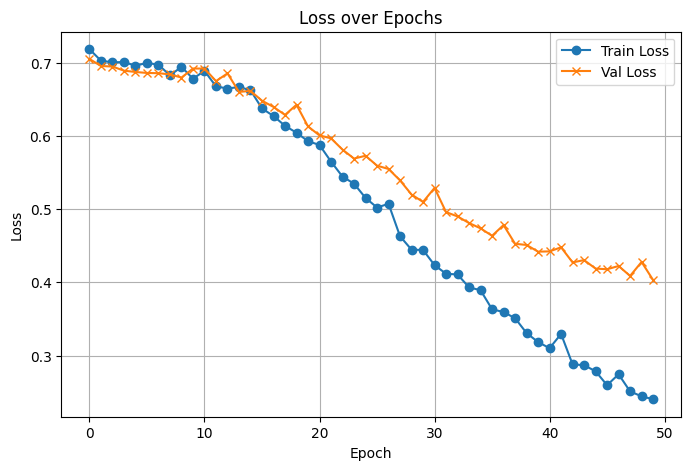

Epoch 50: train=0.2404, val=0.4032


In [ ]:
N_EPOCH = 50
train_losses, val_losses = [], []

for epoch in range(1, N_EPOCH + 1):
    perm = np.random.permutation(len(train_tokens))
    epoch_losses = []

    for i in range(0, len(perm), ft.batch_size):
        batch_idx = perm[i : i + ft.batch_size]
        batch_toks = [train_tokens[j] for j in batch_idx]
        batch_lbls = train_labels[batch_idx]
        batch_df = pd.DataFrame({"text": batch_toks, "label": batch_lbls})

        ft.backward(batch_df)
        epoch_losses.append(ft._loss_vals[-1])

    avg_train = float(np.mean(epoch_losses))
    train_losses.append(avg_train)

    val_df = pd.DataFrame({"text": val_tokens, "label": val_labels})
    vloss = ft.eval(val_df)
    val_losses.append(vloss)

    clear_output(wait=True)
    plt.figure(figsize=(8,5))
    plt.plot(train_losses, marker='o', label='Train Loss')
    plt.plot(val_losses,   marker='x', label='Val Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss over Epochs")
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"Epoch {epoch:2d}: train={avg_train:.4f}, val={vloss:.4f}")

In [ ]:
from collections import defaultdict
import math
import pandas as pd
from tqdm import tqdm

w_diff = ft.weights[:,1] - ft.weights[:,0]
ngram_raw = defaultdict(list)
word_agg = defaultdict(lambda: [0.0, 0])

for text in tqdm(train_texts, desc="Collect diffs"):
    words = tok._split(text)
    ngrams_lst = [tok._ngrams(w) for w in words]
    ids_lst = tok.encode(text)
    for w, ngrams, ids in zip(words, ngrams_lst, ids_lst):
        subsum = 0.0
        seen = set()
        for ng, idx in zip(ngrams, ids):
            if ng in seen:
                continue
            seen.add(ng)
            diff = ft.vocab[idx].dot(w_diff)
            key = ng if tok.subword_mask[idx] else w
            ngram_raw[key].append(diff)
            subsum += diff
        word_agg[w][0] += subsum
        word_agg[w][1] += 1

ngram_rows = []
for ng, arr in ngram_raw.items():
    mu = sum(arr) / len(arr)
    sigma = (math.sqrt(sum((x - mu)**2 for x in arr) / (len(arr)-1))
             if len(arr) > 1 else 0.0)
    ngram_rows.append((ng, mu, sigma, len(arr)))
df_ngrams = pd.DataFrame(ngram_rows, columns=['feature','mean','std','count'])
df_ngrams['abs_mean'] = df_ngrams['mean'].abs()
df_ngrams.sort_values('abs_mean', ascending=False, inplace=True)

word_rows = [(w, s/c, c) for w,(s,c) in word_agg.items() if c>0]
df_words = pd.DataFrame(word_rows, columns=['word','avg_strength','count'])
df_words['abs_strength'] = df_words['avg_strength'].abs()
df_words.sort_values('abs_strength', ascending=False, inplace=True)

print("\nTop k n-grams by |mean impact|:")
print(df_ngrams.head(50).to_string(index=False))

print("\nTop k words by |avg_strength|:")
print(df_words.head(50).to_string(index=False))

Collect diffs: 100%|██████████| 770/770 [00:14<00:00, 54.18it/s]



Top k n-grams by |mean impact|:
   feature       mean       std  count  abs_mean
      xati -72.642395  0.000000      1 72.642395
      rpti -72.642395  0.000000      2 72.642395
      zati -72.642395  0.000000      1 72.642395
      tion -71.130730 10.175481   1998 71.130730
    __id__ -50.496052  0.000099    368 50.496052
      htec -43.478718  0.000000      1 43.478718
      tech -43.359505  2.287271    369 43.359505
      tmay -41.487926  0.000000      2 41.487926
      rmay -41.487926  0.000000      2 41.487926
      mayo -40.608997  6.739604    170 40.608997
      arch -39.675282  1.092962    491 39.675282
     creti -39.606148  0.000000      1 39.606148
   lotions -39.606148  0.000000      1 39.606148
     tions -39.606094  0.000053    521 39.606094
      ualw -38.373322  0.000000      1 38.373322
      ctwo -38.373322  0.000000      1 38.373322
      eamw -38.373322  0.000000      1 38.373322
      ngap -38.373322  0.000000      3 38.373322
      work -38.245975  2.006339    4

In [ ]:
from collections import defaultdict
from tqdm import tqdm

w_diff = ft.weights[:,1] - ft.weights[:,0]

ngram_scores = defaultdict(lambda: defaultdict(float))
ngram_counts = defaultdict(lambda: defaultdict(int))

for text in tqdm(train_texts, desc="Impact"):
    words = tok._split(text)
    ngrams_lst = [tok._ngrams(wd) for wd in words]
    ids_lst = tok.encode(text)

    for word, ngrams, ids in zip(words, ngrams_lst, ids_lst):
        seen = set()
        for ng_str, idx in zip(ngrams, ids):
            if ng_str in seen: continue
            seen.add(ng_str)
            diff = ft.vocab[idx].dot(w_diff)
            key_ng = ng_str if tok.subword_mask[idx] else word
            ngram_scores[key_ng][word] += diff
            ngram_counts[key_ng][word] += 1

# pick the single most impactful word for each ngram
avg_impact = {}
for ng, wd_dict in ngram_scores.items():
    best_w, best_avg = max(
        ((w, s/ngram_counts[ng][w]) for w, s in wd_dict.items()),
        key=lambda x: abs(x[1])
    )
    avg_impact[f"{ng} ({best_w})"] = best_avg

# top 100 by absolute impact
top100 = sorted(avg_impact.items(), key=lambda x: -abs(x[1]))[:100]
for feat, sc in top100:
    print(f"{feat:>25s}: {sc:+.4f}")

Impact: 100%|██████████| 770/770 [00:11<00:00, 67.22it/s]


               you (your): +15.9292
           gsy (ringsyou): +15.9291
          ion (questions): -15.7275
         tio (desorption): -15.7275
         sio (expulsions): -15.7275
         ill (545billion): -15.7275
 nit (speech_recognition): -15.7275
              eio (deion): -15.7275
         xio (complexion): -15.7275
              fio (fiona): -15.7275
         ati (ionization): -15.2449
         pti (desorption): -15.2449
 gni (speech_recognition): -15.2449
         tion (questions): -14.5253
         ntio (retention): -14.5252
        lati (modulation): -14.5252
        atio (levitation): -14.5252
         empt (exemption): -14.5252
        ptio (exceptions): -14.5252
        rati (laceration): -14.5252
          ecti (asection): -14.5252
        ctio (projection): -14.5252
        utio (cautionary): -14.5252
          diti (sedition): -14.5252
         itio (rendition): -14.5252
         nati (snational): -14.5252
         tort (extortion): -14.5252
        exat (annexation): -

---

---

---

In [ ]:
import re, zlib, math
from collections import Counter
from functools import lru_cache

import numpy as np
import pandas as pd

STOPWORDS  = {'the','and','is','in','it','of','to','a','with','that','for','on',
              'as','are','this','but','be','at','or','by','an','if','from',
              'about','into','over','after','under'}
DEPRECATED = {'font','center','marquee','bgsound','spacer'}

_RX_SCRIPT_STYLE   = re.compile(r'<(?:script|style)[^>]*>.*?</(?:script|style)>',
                                re.S|re.I)
_RX_TAG            = re.compile(r'<[^>]+>')
_RX_SENTENCE_SPLIT = re.compile(r'[.!?]+')
_RX_PARAGRAPH      = re.compile(r'\n{2,}')
_RX_TOKENS         = re.compile(r'\w+')
_RX_EMPTY_TAG      = re.compile(r'<(\w+)(?:\s+[^>]*)?>\s*</\1>')
_RX_TAG_NAME       = re.compile(r'<\s*(\w+)', re.I)
_RX_IFRAME         = re.compile(r'<\s*iframe\b', re.I)
_RX_LINK           = re.compile(r'href=["\']([^"\']+)["\']', re.I)
_RX_REL            = re.compile(r'<a[^>]+rel=["\']([^"\']+)["\']', re.I)
_RX_ANCHOR_TEXT    = re.compile(r'<a[^>]*>(.*?)</a>', re.S)
_RX_IMG            = re.compile(r'<\s*img\b', re.I)
_RX_ALT            = re.compile(r'<img[^>]+alt=["\']([^"\']*)', re.I)
_RX_URL            = re.compile(r'https?://\S+')
_RX_REPEAT_PHRASE  = re.compile(r'(\b\w+\b)(?:\s+\1){2,}', re.I)
_RX_SYLLABLES      = re.compile(r'[aeiouy]+', re.I)
_RX_VBG            = re.compile(r'\b\w+ing\b')
_RX_PRP            = re.compile(r'\b(?:I|me|you|he|she|it|we|they|him|her|us|them)\b',
                                re.I)
_RX_RB             = re.compile(r'\b(\w+ly|here|there|now|then)\b', re.I)

EXPRS = {
    "i_x_that_is_not_y_but_z":
        re.compile(r'\bI\s+\w+\s+that\s+is\s+not\s+\w+,\s*but\s+\w+', re.I),
    "as_i_x_i_will_y": 
        re.compile(r'\bAs\s+I\s+\w+,\s*I\s+will\s+\w+', re.I),
    "x_is_not_about_y_its_about_z":
        re.compile(r"\b\w+\s+is\s+not\s+about\s+\w+,\s*it's\s+about\s+\w+", re.I),
}


@lru_cache(maxsize=2**14)
def _feature_dict(html: str) -> dict[str, float]:
    cleaned  = _RX_SCRIPT_STYLE.sub('', html)
    text     = _RX_TAG.sub(' ', cleaned)
    tokens   = _RX_TOKENS.findall(text.lower())
    sentences= [s for s in _RX_SENTENCE_SPLIT.split(text) if s.strip()]
    paragraphs=[p for p in _RX_PARAGRAPH.split(text) if p.strip()]

    tb   = len(html)                             # raw bytes ~ ascii = chars
    ttb  = len(text)
    tags = _RX_TAG_NAME.findall(html.lower())
    n_tags = len(tags) or 1

    feat = {
        'total_bytes':            tb,
        'text_bytes':             ttb,
        'markup_to_text_ratio':   (tb-ttb)/tb if tb else 0,
        'percent_empty_tags':     len(_RX_EMPTY_TAG.findall(html))/n_tags,
        'inline_css_ratio':       html.lower().count('style=')/n_tags,
        'deprecated_tag_ratio':   sum(t in DEPRECATED for t in tags)/n_tags,
        'iframe_count':           len(_RX_IFRAME.findall(html)),
    }

    hrefs   = _RX_LINK.findall(html)
    total_l = len(hrefs)
    ext_l   = sum(u.startswith(('http://','https://')) for u in hrefs)
    int_l   = total_l - ext_l
    nof     = sum('nofollow' in rel.lower() for rel in _RX_REL.findall(html))

    feat |= {
        'total_links':             total_l,
        'external_internal_ratio': ext_l/int_l if int_l else 0,
        'nofollow_ratio':          nof/total_l if total_l else 0,
        'links_per_kb':            total_l/(tb/1024) if tb else 0,
        'avg_anchor_text_length':
            np.mean([len(_RX_TAG.sub('', t).strip())
                     for t in _RX_ANCHOR_TEXT.findall(html) if t.strip()]) or 0,
        'image_count':             len(_RX_IMG.findall(html)),
        'avg_alt_length':
            np.mean(list(map(len, _RX_ALT.findall(html)))) if 'alt="' in html else 0,
    }

    sw   = sum(t in STOPWORDS for t in tokens)
    syls = [max(1, len(_RX_SYLLABLES.findall(w))) for w in tokens]
    wps  = [len(_RX_TOKENS.findall(s)) for s in sentences]
    spp  = [len(_RX_SENTENCE_SPLIT.split(p)) for p in paragraphs]

    feat |= {
        'stopword_ratio':          sw/len(tokens) if tokens else 0,
        'syllables_per_word':      np.mean(syls) if syls else 0,
        'words_per_sentence':      np.mean(wps) if wps else 0,
        'sentences_per_paragraph': np.mean(spp) if spp else 0,
        'vbg':                     len(_RX_VBG.findall(text)),
        'prp':                     len(_RX_PRP.findall(text)),
        'rb':                      len(_RX_RB.findall(text)),
        'straight_apostrophe':     text.count("'"),
        'curly_apostrophe':        text.count("’"),
        'emdash':                  text.count("—"),
        'url_count':               len(_RX_URL.findall(html)),
        'repeated_phrase_count':   len(_RX_REPEAT_PHRASE.findall(text)),
        'compression_length':      len(zlib.compress(html.encode())),
    }

    for k,p in EXPRS.items():
        feat[k] = len(p.findall(text))

    words = len(tokens)
    sents = len(sentences) or 1
    freq  = Counter(tokens)

    feat |= {
        'flesch_kincaid_grade': 0.39*(words/sents) +
                                 11.8*(np.mean(syls) if syls else 0) - 15.59,
        'shannon_entropy':     -sum((c/words)*math.log2(c/words)
                                    for c in freq.values()) if words else 0,
        'type_token_ratio':     len(freq)/words if words else 0,
        # 'tag_histogram':        dict(Counter(tags)),
        #'word_frequencies':     dict(freq),
        'total_tags':           n_tags,
        'total_tokens':         len(tokens),
    }
    return feat


def build_features_df(texts: list[str]) -> pd.DataFrame:
    df = pd.DataFrame.from_records(map(_feature_dict, texts))

    token_tot = df['total_tokens']
    tag_tot   = df['total_tags']
    for col in ['vbg','prp','rb']:
        df[f'{col}_ratio'] = df[col] / token_tot

    df['external_internal_ratio'].fillna(0, inplace=True)
    df['avg_anchor_text_length'].fillna(0, inplace=True)
    return df


In [16]:
import re, html

URL_RE = re.compile(r'https?://\S+|www\.\S+')
MAIL_RE = re.compile(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Za-z]{2,}\b')
NUM_RE = re.compile(r'\b\d+(?:[\.,]\d+)*\b')
UUID_RE = re.compile(r'\b[0-9a-fA-F]{8}-[0-9a-fA-F]{4}-'
                       r'[0-9a-fA-F]{4}-[0-9a-fA-F]{4}-'
                       r'[0-9a-fA-F]{12}\b')
HEX_RE = re.compile(r'\b0x[0-9A-Fa-f]+\b|\b[0-9A-Fa-f]{6,}\b')
SKU_RE = re.compile(r'\b[A-Z]{2,5}[-_]\d{3,6}\b')
INVOICE_RE = re.compile(r'\b(?:INV|ORD|TXN)\d{4,8}\b')
SLUG_RE = re.compile(r'\b(?=[A-Za-z0-9]*[A-Za-z])(?=[A-Za-z0-9]*\d)'
                       r'[A-Za-z0-9]{8,}\b')
ID_RE = re.compile(r'\b(?=[A-Za-z0-9]*[A-Za-z])(?=[A-Za-z0-9]*\d)'
                       r'[A-Za-z0-9]{4,}\b')
ISO_RE = re.compile(r'\b\d{4}-\d{2}-\d{2}[tT]\d{2}:\d{2}:\d{2}(?:\.\d+)?Z\b')
WS_RE = re.compile(r'\s+')
BLOCK_RE = re.compile(r'(?is)<(script|style|template|noscript)[\s>][^>]*>.*?</\1\s*>')
TAG_RE = re.compile(r'(?s)</?([A-Za-z][\w:-]*)[^>]*?>')
LEN_RE = re.compile(r'(?i)\b(?:[a-z]{1,3}|[a-z]{11,})\b')
SUFFIX_RE = re.compile(r'(?i)\b[a-z]*(?:ing|ers?)\b')
COMMENT_RE = re.compile(r'(?s)<!--.*?-->')
ALT_TITLE_RE = re.compile(r'(?i)\b(?:alt|title)\s*=\s*"([^"]*)"')
STOP_TRIGRAM_RE = re.compile(r'(?i)\b[a-z]*(?:hat|tha|nth|tth|sth)[a-z]*\b')

def preprocess_fn(text: str) -> str:
    text = BLOCK_RE.sub(lambda m: f' __tag_{m.group(1).lower()}__ ', text)
    text = TAG_RE.sub   (lambda m: f' __tag_{m.group(1).lower()}__ ', text)

    text = html.unescape(text)

    text = URL_RE.sub(' __url__ ',  text)
    text = MAIL_RE.sub(' __email__ ', text)
    text = ISO_RE.sub(' __iso_date__ ', text)
    text = NUM_RE.sub(' __num__ ', text)
    text = UUID_RE.sub(' __uuid__ ', text)
    text = HEX_RE.sub(' __hex__ ', text)
    text = SKU_RE.sub(' __sku__ ', text)
    text = INVOICE_RE.sub(' __invoice__ ', text)
    text = SLUG_RE.sub(' __slug__ ', text)
    text = ID_RE.sub(' __id__ ', text)

    text = LEN_RE.sub(' ', text)
    text = SUFFIX_RE.sub('', text)
    text = COMMENT_RE.sub(' ', text)
    text =  ALT_TITLE_RE.sub(' ', text)
    text = STOP_TRIGRAM_RE.sub(' ', text)

    text = WS_RE.sub(' ', text).lower().strip()
    return text



tok = tokenizer.FastTextTokenizer(
    bucket_size=int(5e5),
    ngram_size=(4, 5),
    min_subword_freq=10,
    max_token=200,
    preprocess_fn=preprocess_fn,
)
tok.build_subword_mask([ex["text"] for ex in train_ds])

In [17]:
train_texts  = [ex["text"]  for ex in train_ds]
train_labels = np.array([ex["label"] for ex in train_ds])
train_tokens = tok.batch_encode(train_texts)

val_texts  = [ex["text"]  for ex in val_ds]
val_labels = np.array([ex["label"] for ex in val_ds])
val_tokens = tok.batch_encode(val_texts)

train_feat = build_features_df(train_texts)
val_feat   = build_features_df(val_texts)

train_df = pd.concat(
    [pd.DataFrame({"text": train_tokens, "label": train_labels}), train_feat],
    axis=1, copy=False
)
val_df = pd.concat(
    [pd.DataFrame({"text": val_tokens, "label": val_labels}), val_feat],
    axis=1, copy=False
)

/mnt/c/Users/ASUS/Documents/GitHub/stop_slop/.venv/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/mnt/c/Users/ASUS/Documents/GitHub/stop_slop/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_4319/3937907480.py:137: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['external_internal_ratio'].fillna(0, i

In [18]:
ft = fasttext.FastTextModel(
    num_class=2,
    lr=0.01,
    emb_size=50,
    batch_size=32,
    bucket_size=int(5e5),
    dropout_rate=0.2,
    reg_lambda=1e-3,
    max_grad_norm=1.0
)

2025-05-19 21:32:49,184 [INFO] Initializing config
2025-05-19 21:32:49,194 [INFO] Initializing parameters
2025-05-19 21:32:50,296 [INFO] Initializing vals


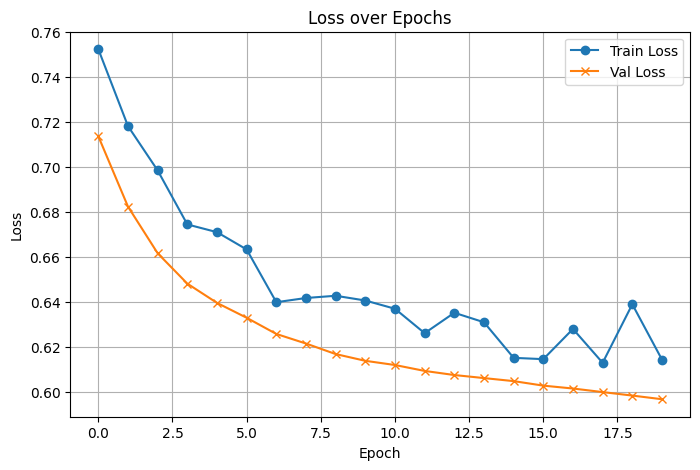

KeyboardInterrupt: 

In [19]:
N_EPOCH = 30
train_losses, val_losses = [], []


ft.fit_scaler(train_df)

for epoch in range(1, N_EPOCH + 1):
    perm = np.random.permutation(len(train_df))
    epoch_losses = []

    for i in range(0, len(perm), ft.batch_size):
        batch_df = train_df.iloc[perm[i : i + ft.batch_size]].reset_index(drop=True)
        ft.backward(batch_df)
        epoch_losses.append(ft._loss_vals[-1])

    train_losses.append(float(np.mean(epoch_losses)))
    val_losses.append(ft.eval(val_df))

    clear_output(wait=True)
    plt.figure(figsize=(8,5))
    plt.plot(train_losses, marker='o', label='Train Loss')
    plt.plot(val_losses,   marker='x', label='Val Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss over Epochs")
    plt.legend()
    plt.grid(True)
    plt.show()

    #print(f"Epoch {epoch:2d}: train={avg_train:.4f}, val={vloss:.4f}")

In [ ]:
from collections import defaultdict
from tqdm import tqdm

w_diff = ft.weights[:,1] - ft.weights[:,0]

ngram_scores = defaultdict(lambda: defaultdict(float))
ngram_counts = defaultdict(lambda: defaultdict(int))

for text in tqdm(train_texts, desc="Impact"):
    words = tok._split(text)
    ngrams_lst = [tok._ngrams(wd) for wd in words]
    ids_lst = tok.encode(text)

    for word, ngrams, ids in zip(words, ngrams_lst, ids_lst):
        seen = set()
        for ng_str, idx in zip(ngrams, ids):
            if ng_str in seen: continue
            seen.add(ng_str)
            diff = ft.vocab[idx].dot(w_diff)
            key_ng = ng_str if tok.subword_mask[idx] else word
            ngram_scores[key_ng][word] += diff
            ngram_counts[key_ng][word] += 1

# pick the single most impactful word for each ngram
avg_impact = {}
for ng, wd_dict in ngram_scores.items():
    best_w, best_avg = max(
        ((w, s/ngram_counts[ng][w]) for w, s in wd_dict.items()),
        key=lambda x: abs(x[1])
    )
    avg_impact[f"{ng} ({best_w})"] = best_avg

# top 100 by absolute impact
top100 = sorted(avg_impact.items(), key=lambda x: -abs(x[1]))[:100]
for feat, sc in top100:
    print(f"{feat:>25s}: {sc:+.4f}")

Impact: 100%|██████████| 770/770 [00:16<00:00, 46.76it/s]


         tion (inflation): -67.3223
        atio (laceration): -67.3223
        ptio (redemption): -67.3223
         ctio (abduction): -67.3223
          itio (sedition): -67.3223
        xati (annexation): -67.3223
        stio (combustion): -67.3223
ogni (speech_recognition): -67.3223
         tati (lactation): -67.3223
        icti (nonfiction): -67.3223
        snat (newsnation): -67.3223
           otio (lotions): -67.3223
         orti (extortion): -67.3223
        rcti (infarction): -67.3223
         mpti (exemption): -67.3223
        rpti (desorption): -67.3223
        zati (ionization): -67.3223
          __id__ (__id__): -44.9470
         tech (technical): -40.7217
        htec (thoughtech): -40.7217
              mayo (mayo): -36.5243
         byma (lobbymayo): -36.5242
            tmay (atmayo): -36.5242
        rmay (centermayo): -36.5242
          clinic (clinic): -34.4570
              your (your): +34.3663
         uney (pruneyour): +34.3662
            hien (chieng): +

In [ ]:
df_feats = build_features_df(val_texts)

all_feat_names = df_feats.columns.tolist()
numeric_feats = [
    col for col in all_feat_names
    if np.issubdtype(df_feats[col].dtype, np.number)
]

assert ft.exp_feats == len(numeric_feats), \
    f"Expected {ft.exp_feats} numeric features but found {len(numeric_feats)}"

emb = ft.emb_size
num_w = ft.weights[emb : emb + len(numeric_feats), :]   # shape (31, 2)

w_diff = num_w[:, 1] - num_w[:, 0]

for feat, weight in sorted(zip(numeric_feats, w_diff), key=lambda x: -abs(x[1])):
    print(f"{feat:>30}: {weight:+.4f}")

AttributeError: 'FastTextModel' object has no attribute 'exp_feats'